In [1]:
import pandas as pd
import numpy as np
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

## Hybrid Model

Small example

In [8]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

In [9]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]
sample_season_scores.to_csv('viz/sample_season_scores.csv') # Save for Google sheets

In [10]:
# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
season_pivot.to_csv('viz/season_pivot.csv') # Save for Google sheets

In [11]:
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 
# array([[   nan,    nan, 192.14],
#        [   nan, 285.38, 292.98],
#        [226.07, 229.06,    nan],
#        [222.13, 248.42,    nan]])

In [12]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), 1))
event_scores = random_state.random_sample((1, len(event_names)))

pd.Series(skater_scores.ravel(), index=skater_names).to_csv('viz/skater_scores.csv') # Save for Google sheets
pd.Series(event_scores.ravel(), index=event_names).to_csv('viz/event_scores.csv') # Save for Google sheets

In [13]:
# Run gradient descent algorithm for toy example
alpha = 0.0005

for i in range(1000):
    # 2a. Calculate gradients
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    baseline_gradient = np.nansum(residuals)
    event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
    skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
    
    ### 2b. Update latent scores using gradients
    baseline = baseline - alpha * baseline_gradient
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    # Print RMSE for last two iterations
    if i in [998, 999]:
        print(i, np.sqrt(np.nanmean(residuals**2)))

998 4.30230107376627
999 4.3023010703588165


In [15]:
# Iteration-to-iteration RMSE change at the end
4.3023010703588165-4.30230107376627

-3.407453874615385e-09

In [16]:
# Final skater scores after gradient descent
pd.Series(skater_scores.ravel(), index=skater_names).sort_values(ascending=False)
# Javier, FERNANDEZ     16.701678
# Takahito, MURA        14.101404
# Misha, GE             13.587320
# Alexander, MAJOROV    10.678634

Javier, FERNANDEZ     16.701678
Takahito, MURA        14.101404
Misha, GE             13.587320
Alexander, MAJOROV    10.678634
dtype: float64

Batch gradient descent

In [17]:
def batch_gd(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000,
             log_iter=False, log_every=10, additional_iter=range(1, 10),
             return_rmse=False):
    '''
    Run gradient descent on some season scores table (long format)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
    random_state = np.random.RandomState(init_seed)
    skater_scores = random_state.random_sample((len(skater_names), 1))
    event_scores = random_state.random_sample((1, len(event_names)))
    baseline = random_state.random_sample()
    
    # Different lists to contain intermediate values if logging is enabled
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    residual_log = []
    iter_log = []
    
    # Run gradient descent
    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations if logging is enabled
        if log_iter and (i%log_every==0 or (i in additional_iter)):            
            iter_log.append(i)
            skater_scores_log.append(pd.Series(skater_scores.ravel(), index=skater_names))
            event_scores_log.append(pd.Series(event_scores.ravel(), index=event_names))
            baseline_log.append(baseline)
            residual_log.append(residuals)
            rmse = np.sqrt(np.nanmean(residuals**2))
            rmse_log.append(rmse)
        
        # Calculate parameter gradients
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
        baseline_gradient = np.nansum(residuals)
        
        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient
        
        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
    # Collect logs together in one list
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]
    
    # Put event and skater scores back into Series form with names added
    skater_scores = pd.Series(skater_scores.ravel(), index=skater_names).sort_values(ascending=False)
    event_scores = pd.Series(event_scores.ravel(), index=event_names).sort_values(ascending=False)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    elif return_rmse:
        return baseline, event_scores, skater_scores, rmse_new
    else:
        return baseline, event_scores, skater_scores

Animation of gradient descent

In [18]:
# Final results after 151 iterations
final_baseline, final_event_scores, final_skater_scores = batch_gd(season_scores, alpha=0.0005, n_iter=151)

# Store final skater order to be used in heatmap later
example_skater_order = final_skater_scores.index[::-1]
np.save('viz/example_skater_order', example_skater_order)

Alpha: 0.0005, Iter: 151, Last RMSE: 8.86, Delta RMSE: -1.76e-08


In [19]:
# Logged results during 151 iterations, using skater ranking from the final 150th iteration (only for asthetic reason)
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log] = batch_gd(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=151,
log_iter=True, log_every=10,
additional_iter=list(range(10)) + list(range(10, 51, 5)),
)

rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]
taus_log = [calculate_kendall_tau(season_ranking, world_ranking, verbose=False) for season_ranking in rankings_log]

Alpha: 0.0005, Iter: 151, Last RMSE: 8.86, Delta RMSE: -1.78e-08


In [20]:
def update(i, fig, ax1, ax2, ax3, ax4, verbose=False):
    if verbose:
        print(i)
    
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', fontsize=20)
    residuals = residual_log[i]
    ax1.imshow(-residuals, cmap='coolwarm', vmin=-30, vmax=30) # Neagtive residual: red, positive: blue
    ax1.set_yticklabels(['{0:.2f}'.format(score) for score in skater_scores_log[i]], fontsize=10)
    ax1.set_xticklabels(['{0:.2f}'.format(score) for score in event_scores_log[i]], fontsize=10, rotation=90) 
    baseline_text.set_text('{0:.2f}'.format(baseline_log[i]))

    if i == 0:
        ax2.plot(iter_log[i], rmse_log[i], '.', color='tab:brown', clip_on=False)
    if i >= 1:
        ax2.plot(iter_log[i-1:i+1], rmse_log[i-1:i+1], '.-', color='tab:brown', clip_on=False)
        
    if i == 0:
        ax3.plot(iter_log[i], taus_log[i], '.', color='tab:orange', clip_on=False)
    if i >= 1:
        ax3.plot(iter_log[i-1:i+1], taus_log[i-1:i+1], '.-', color='tab:orange', clip_on=False)

    ax4.lines = []
    ax4.texts = []
    cmap = mpl.cm.get_cmap('winter')
    predicted_ranking = rankings_log[i]
    n_skaters = len(world_ranking)
 
    for index, skater in enumerate(world_ranking):
        # For each skater in world ranking, query his rank in the predicted ranking
        world_rank = index + 1
        predicted_rank = predicted_ranking.index(skater) + 1
        
        # Get y-positions for each rank: lower rank number (1) means higher y-position (on top)
        world_index = n_skaters - world_rank
        predicted_index = n_skaters - predicted_rank
        
        # Get color tuple for each skater in the world ranking
        world_color = cmap(world_rank/(n_skaters*1.1))
        
        # Plot connecting lines between two rankings
        ax4.plot([0, 1], [predicted_index, world_index], 'o-', color=world_color)
        
        # Plot text on both sides
        ax4.text(1.1, world_index, f'{world_rank} {skater}', ha='left', va='center', color=world_color, fontsize=9)
        ax4.text(-0.1, predicted_index, f'{skater} {predicted_rank}', ha='right', va='center', color=world_color, fontsize=9)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0


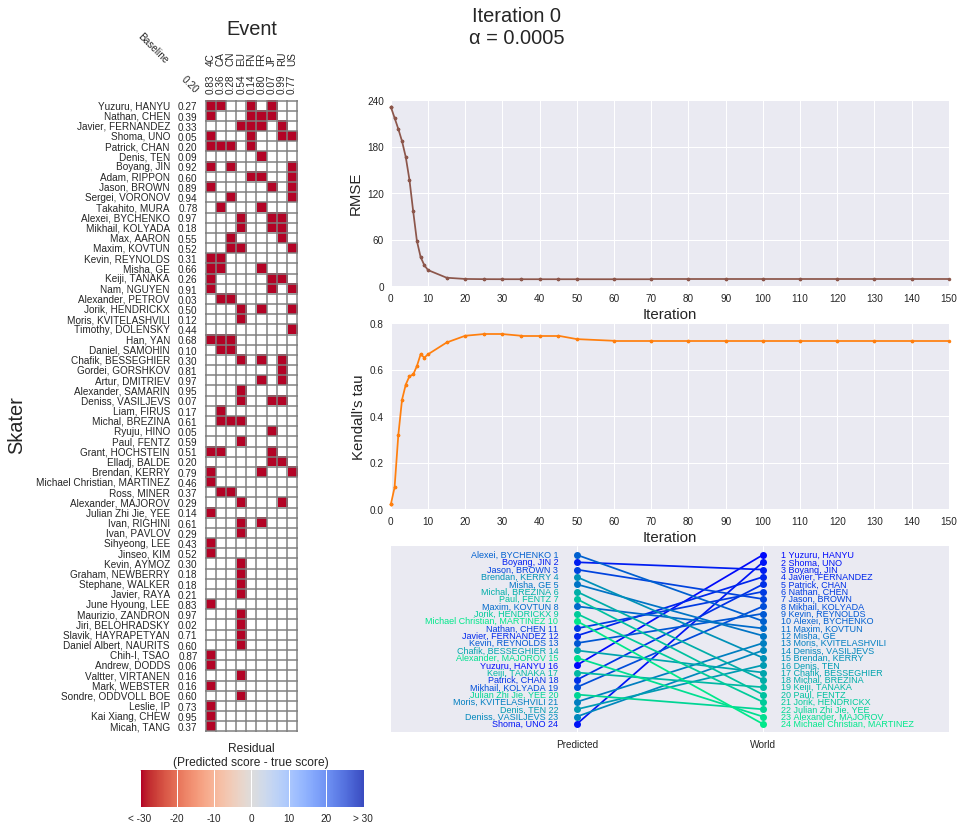

In [21]:
# Set up figure grid
fig = plt.figure(figsize=(15, 13))
grid = plt.GridSpec(10, 3, wspace=0, hspace=1)


# Set up heat map of residuals
ax1 = fig.add_subplot(grid[:-1, 0])
ax1.set_xticks(np.arange(-.5, len(event_names), 1), minor=True)
ax1.set_yticks(np.arange(-.5, len(skater_names), 1), minor=True)
ax1.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax1.grid(None, which='major')
ax1.set_xlim(-0.6, len(event_names)-0.4)
ax1.set_xticks(range(len(event_names)))
ax1.xaxis.tick_top()
ax1.set_ylim(-0.6, len(skater_names)-0.45)
ax1.set_yticks(range(len(skater_names)))
ax1.set_facecolor('white')

for i, skater in enumerate(skater_names):
    ax1.text(x=-4, y=i-0.3, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax1.text(x=i-0.5, y=len(skater_names)+3, s=event, rotation=90, va='bottom')
ax1.text(x=-4, y=len(skater_names)+3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax1.text(x=-1, y=len(skater_names)+0.1, s='', rotation=-45, va='bottom', ha='right')
ax1.text(x=-20, y=len(skater_names)/2, s='Skater', rotation=90, fontsize=20)
ax1.text(x=4, y=len(skater_names)+6, s='Event', fontsize=20, ha='center')

# Set up RMSE plot
ax2 = fig.add_subplot(grid[:3, 1:])
ax2.set_xlim(0, iter_log[-1])
ax2.set_xticks(range(0, iter_log[-1]+1, 10))
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylim(0, 240)
ax2.set_yticks(np.arange(0, 241, 60))
ax2.set_ylabel('RMSE', fontsize=15)

# Set up Kendall's tau plot
ax3 = fig.add_subplot(grid[3:6, 1:])
ax3.set_xlim(0, iter_log[-1])
ax3.set_xticks(range(0, iter_log[-1]+1, 10))
ax3.set_xlabel('Iteration', fontsize=15)
ax3.set_ylim(0, 0.8)
ax3.set_yticks(np.arange(0, 0.81, 0.2))
ax3.set_ylabel("Kendall's tau", fontsize=15)

# Set up ranking comparison plot
ax4 = fig.add_subplot(grid[6:9, 1:])
ax4.set_xlim(-1, 2)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['Predicted', 'World'])
ax4.set_yticks([])

# Plot colorbar of residual
ax5 = fig.add_subplot(grid[9, 0])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N, -1, -1)) # Plot colorbar from red to blue (not blue to red)
ax5.imshow([colors], extent=[-30, 30, 0, 10])
ax5.xaxis.set_label_position('top') 
ax5.set_xlabel('Residual\n(Predicted score - true score)', fontsize=12)
ax5.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
ax5.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax1, ax2, ax3, ax4, verbose=True), 
                     frames=len(iter_log), interval=500, repeat_delay=3000)

anim.save('viz/batch_anim.gif', writer='imagemagick')

### Result

In [22]:
# Rerun hybrid model with large number of iterations (10000)
baseline, event_scores, skater_scores = batch_gd(season_scores, alpha=0.0005, n_iter=10000)

Alpha: 0.0005, Iter: 10000, Last RMSE: 8.86, Delta RMSE: -1.7e-08


In [23]:
baseline

78.3675749937978

In [24]:
skater_scores.head()

Yuzuru, HANYU        11.426179
Nathan, CHEN         10.811319
Javier, FERNANDEZ    10.705738
Shoma, UNO           10.695286
Patrick, CHAN        10.151867
dtype: float64

In [25]:
event_scores

EU    20.692112
4C    19.738181
RU    19.423996
CN    19.354095
US    19.233227
FR    18.882618
FN    18.378110
CA    18.114142
JP    18.043503
dtype: float64

### Comparison with other models

In [26]:
# Join hybrid model result back to season scores to calculate predicted score and residual for every event-skater pair
df_compare_hyb = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_hyb = pd.merge(df_compare_hyb, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_hyb['predicted'] = baseline + df_compare_hyb['event_score'] * df_compare_hyb['skater_score']
df_compare_hyb['residual'] = df_compare_hyb['predicted'] - df_compare_hyb['score']
df_compare_hyb.head()
# df_compare_mul.to_csv('data/df_compare_mul.csv')

,name,year,event,score,event_score,skater_score,predicted,residual
1743,"Shoma, UNO",2017,US,279.34,19.233227,10.695286,284.072437,4.732437
1744,"Jason, BROWN",2017,US,268.38,19.233227,8.744312,246.548909,-21.831091
1745,"Adam, RIPPON",2017,US,261.43,19.233227,9.336792,257.944205,-3.485795
1746,"Sergei, VORONOV",2017,US,245.28,19.233227,8.611549,243.995450,-1.284550
1747,"Boyang, JIN",2017,US,245.08,19.233227,9.535276,261.761709,16.681709


In [27]:
df_compare_hyb.loc[df_compare_hyb['name']=='Yuzuru, HANYU']

,name,year,event,score,event_score,skater_score,predicted,residual
1754,"Yuzuru, HANYU",2017,CA,263.06,18.114142,11.426179,285.343001,22.283001
1798,"Yuzuru, HANYU",2017,JP,301.47,18.043503,11.426179,284.535870,-16.934130
1809,"Yuzuru, HANYU",2017,FN,293.90,18.378110,11.426179,288.359147,-5.540853
1840,"Yuzuru, HANYU",2017,4C,303.71,19.738181,11.426179,303.899569,0.189569


In [28]:
# Import similar dataframe from additive model in part 1 (which also includes season average scores for each row)
df_compare_add = pd.read_csv('data/df_compare_add.csv', index_col=0)
df_compare_add.head()

,name,year,event,score,event_score,skater_score,avg,baseline,baseline_event,predicted,residual
1743,"Shoma, UNO",2017,US,279.34,-4.609353,26.752743,283.742500,262.830649,258.221296,284.974040,5.634040
1744,"Jason, BROWN",2017,US,268.38,-4.609353,-11.758589,244.233333,262.830649,258.221296,246.462707,-21.917293
1745,"Adam, RIPPON",2017,US,261.43,-4.609353,0.000000,254.020000,262.830649,258.221296,258.221296,-3.208704
1746,"Sergei, VORONOV",2017,US,245.28,-4.609353,-13.772388,244.520000,262.830649,258.221296,244.448908,-0.831092
1747,"Boyang, JIN",2017,US,245.08,-4.609353,3.904858,263.710000,262.830649,258.221296,262.126155,17.046155


In [29]:
# Import similar dataframe from multiplicative model in part 1
df_compare_mul = pd.read_csv('data/df_compare_mul.csv', index_col=0)
df_compare_mul.head()

,name,year,event,score,event_score,skater_score,avg,baseline,baseline_event,predicted,residual
1743,"Shoma, UNO",2017,US,279.34,0.982756,1.105957,283.742500,262.64223,258.113317,285.462120,6.122120
1744,"Jason, BROWN",2017,US,268.38,0.982756,0.953747,244.233333,262.64223,258.113317,246.174780,-22.205220
1745,"Adam, RIPPON",2017,US,261.43,0.982756,1.000000,254.020000,262.64223,258.113317,258.113317,-3.316683
1746,"Sergei, VORONOV",2017,US,245.28,0.982756,0.947786,244.520000,262.64223,258.113317,244.636073,-0.643927
1747,"Boyang, JIN",2017,US,245.08,0.982756,1.014664,263.710000,262.64223,258.113317,261.898239,16.818239


In [30]:
# Calculate height of decorative vertical white bar for each season score

avg_residual = (df_compare_add['avg']-df_compare_add['score']).values
add_residual = df_compare_add['residual'].values
mul_residual = df_compare_mul['residual'].values
hyb_residual = df_compare_hyb['residual'].values

heights = []
for residual_quad in zip(avg_residual, add_residual, mul_residual, hyb_residual):
    max_residual, min_residual = max(residual_quad), min(residual_quad)
    if abs(max_residual) > abs(min_residual):
        height = max_residual
    else:
        height = min_residual
    heights.append(height)

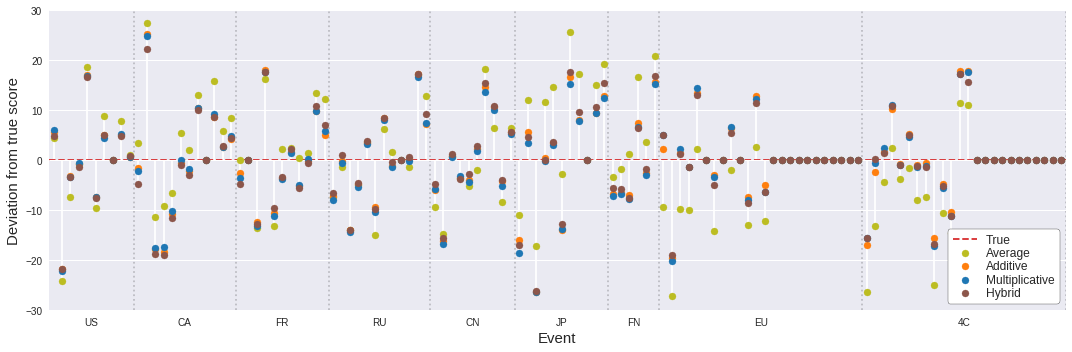

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot dotted red line at zero
ax.axhline(0, color='tab:red', zorder=0, ls='--', label='True')

# Plot dots for residuals
x_coords = np.arange(len(df_compare_mul))
ax.scatter(x_coords, df_compare_add['avg']-df_compare_add['score'], color='tab:olive', label='Average', zorder=1)
ax.scatter(x_coords, df_compare_add['predicted']-df_compare_add['score'], color='tab:orange', label='Additive', zorder=2)
ax.scatter(x_coords, df_compare_mul['predicted']-df_compare_mul['score'], color='tab:blue', label='Multiplicative', zorder=3)
ax.scatter(x_coords, df_compare_hyb['predicted']-df_compare_hyb['score'], color='tab:brown', label='Hybrid', zorder=4)

# Plot decorative white bars for each event
ax.vlines(x=x_coords, ymin=[0]*len(heights), ymax=heights, color='white', zorder=0)

# Hide vertical grid
ax.grid(axis='x')

# Plot gridlines between events instead
events = df_compare_hyb['event'].drop_duplicates()
event_counts = df_compare_hyb['event'].value_counts().loc[events]
for count in event_counts.cumsum():
    ax.axvline(count-0.5, color='black', alpha=0.2, ls='dotted', zorder=0)
ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
ax.set_xticklabels(events)

ax.legend(loc='lower right', **legend_opts)

ax.set_xlim([-0.5, len(x_coords)-0.5])
ax.set_xlabel('Event', fontsize=15)
ax.set_ylim([-30, 30])
ax.set_ylabel('Deviation from true score', fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/resid_hyb_avg_add_mul.png')

In [32]:
# Load ranking of previous models for 2017 season
add_ranking = list(np.load('data/add_ranking_2017.npy'))
mul_ranking = list(np.load('data/mul_ranking_2017.npy'))
hyb_ranking, world_ranking = return_ranking(skater_scores, world_scores)

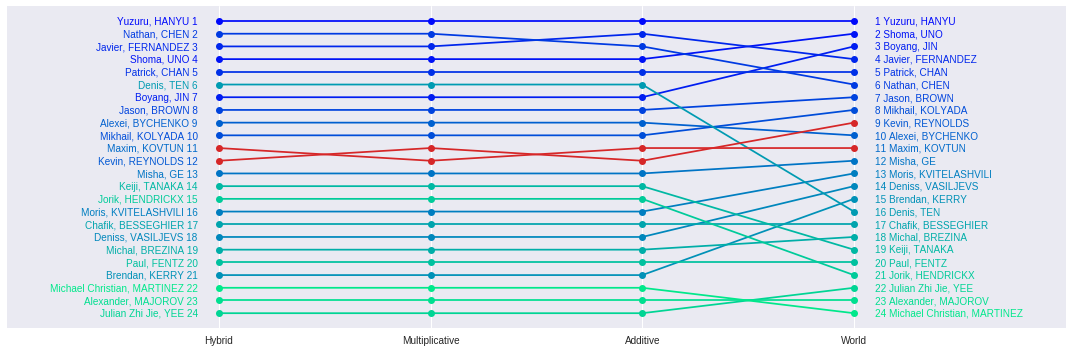

In [33]:
# Compare ranking of hybrid to earlier models
fig, ax = plt.subplots(figsize=(15, 5))
plot_multiple_rankings(fig, ax, [hyb_ranking, mul_ranking, add_ranking, world_ranking],
                       ['Hybrid', 'Multiplicative', 'Additive', 'World'])
for line_id in [10, 8]:
    del ax.lines[line_id]
# ax.plot(range(4), [22, 22, 21, 18], 'o-', color='tab:red')
# ax.plot(range(4), [21, 21, 22, 20], 'o-', color='tab:red')
ax.plot(range(4), [13, 12, 13, 13], 'o-', color='tab:red')
ax.plot(range(4), [12, 13, 12, 15], 'o-', color='tab:red')
fig.savefig('viz/rank_hyb_mul_add_world.png')

In [34]:
season_ranking, world_ranking = return_ranking(skater_scores, world_scores)
hyb_tau, hyb_concord, hyb_pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
hyb_tau, hyb_concord

(0.7246376811594203, 238)

## Model penalization

Small example

In [35]:
# Same setup as before, but with extra regularization term (lambda_param) when calculating gradients
skater_names = list(season_pivot.index) 
event_names = list(season_pivot.columns) 
true_scores = season_pivot.values 

random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), 1))
event_scores = random_state.random_sample((1, len(event_names)))

alpha = 0.0005
lambda_param = 10

for i in range(1000):
    # 2a. Calculate gradients
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    baseline_gradient = np.nansum(residuals)
    event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True) + lambda_param * event_scores
    skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True) + lambda_param * skater_scores
    
    ### 2b. Update latent scores using gradients
    baseline = baseline - alpha * baseline_gradient
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    if i in [998, 999]:
        print(i, np.sqrt(np.nanmean(residuals**2)))
        
pd.Series(skater_scores.ravel(), index=skater_names).sort_values(ascending=False)
# Javier, FERNANDEZ     16.108775
# Takahito, MURA        13.429787
# Misha, GE             12.893933
# Alexander, MAJOROV     9.784296

998 6.556334468634896
999 6.556316469926324


Javier, FERNANDEZ     16.108775
Takahito, MURA        13.429787
Misha, GE             12.893933
Alexander, MAJOROV     9.784296
dtype: float64

Evaluate over 2017 male skaters

In [36]:
def batch_gd_penalized(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, lambda_param=0,
             log_iter=False, log_every=10, additional_iter=range(1, 10),
             return_rmse=False):
    '''
    Run gradient descent on some season scores table (long format) with penalization (controlled by lambda_param)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
    random_state = np.random.RandomState(init_seed)
    skater_scores = random_state.random_sample((len(skater_names), 1))
    event_scores = random_state.random_sample((1, len(event_names)))
    baseline = random_state.random_sample()
    
    # Different lists to contain intermediate values if logging is enabled
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    residual_log = []
    iter_log = []
    
    # Run gradient descent
    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations if logging is enabled
        if log_iter and (i%log_every==0 or (i in additional_iter)):            
            iter_log.append(i)
            skater_scores_log.append(pd.Series(skater_scores.ravel(), index=skater_names))
            event_scores_log.append(pd.Series(event_scores.ravel(), index=event_names))
            baseline_log.append(baseline)
            residual_log.append(residuals)
            rmse = np.sqrt(np.nanmean(residuals**2))
            rmse_log.append(rmse)
        
        # Calculate parameter gradients
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True) + lambda_param * skater_scores
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True) + lambda_param * event_scores
        baseline_gradient = np.nansum(residuals)
        
        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient
        
        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Lambda: {lambda_param}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
    # Collect logs together in one list
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]
    
    # Put event and skater scores back into Series form with names added
    skater_scores = pd.Series(skater_scores.ravel(), index=skater_names).sort_values(ascending=False)
    event_scores = pd.Series(event_scores.ravel(), index=event_names).sort_values(ascending=False)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    elif return_rmse:
        return baseline, event_scores, skater_scores, rmse_new
    else:
        return baseline, event_scores, skater_scores

Evaluate effect of lambda on RMSE, Kendall's tau, and predicted ranking of model

In [37]:
lambda_values = [0] + list(10**np.arange(-3, 3, dtype=float))
lambda_labels = [int(l) if l>=1 else l for l in lambda_values]
lambda_values

[0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [38]:
# Store baseline, skater scores, RMSE, tau, and concordant pairs for different values of lambda
baselines_lambda = []
skater_scores_lambda = []
rmses_lambda = []
taus_lambda = []
concords_lambda = []

for lambda_param in lambda_values:
    baseline, event_scores, skater_scores, rmse = batch_gd_penalized(season_scores,
                                                               alpha=0.0005, n_iter=10000, lambda_param=lambda_param,
                                                               return_rmse=True)
    baselines_lambda.append(baseline)
    skater_scores_lambda.append(skater_scores)
    rmses_lambda.append(rmse)

# Get skater ranking from skater scores at different values of lambda
rankings_lambda = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_lambda]
world_ranking = return_ranking(skater_scores_lambda[0], world_scores)[1]

# Calculate tau and number of concordant pairs for different values of lambda
for season_ranking in rankings_lambda:
    tau, n_concord, _ = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
    taus_lambda.append(tau)
    concords_lambda.append(n_concord)

Alpha: 0.0005, Lambda: 0, Iter: 10000, Last RMSE: 8.86, Delta RMSE: -1.7e-08
Alpha: 0.0005, Lambda: 0.001, Iter: 10000, Last RMSE: 8.86, Delta RMSE: -1.51e-08
Alpha: 0.0005, Lambda: 0.01, Iter: 10000, Last RMSE: 8.86, Delta RMSE: 2.1e-09
Alpha: 0.0005, Lambda: 0.1, Iter: 10000, Last RMSE: 8.86, Delta RMSE: 2.048e-07
Alpha: 0.0005, Lambda: 1.0, Iter: 10000, Last RMSE: 8.92, Delta RMSE: 1.31532e-05
Alpha: 0.0005, Lambda: 10.0, Iter: 10000, Last RMSE: 9.69, Delta RMSE: 0.0
Alpha: 0.0005, Lambda: 100.0, Iter: 10000, Last RMSE: 20.33, Delta RMSE: 0.0


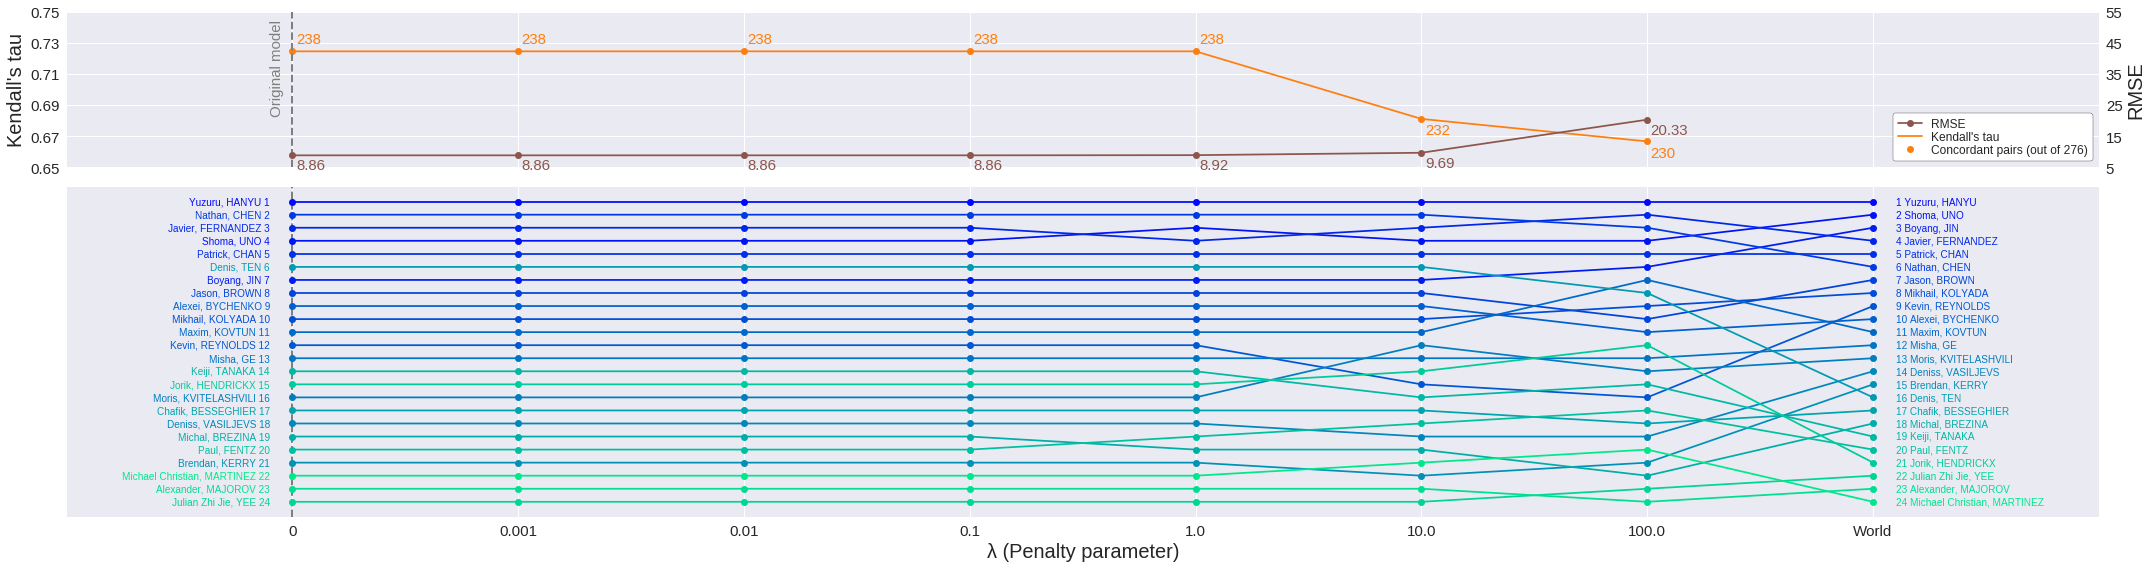

In [39]:
fig = plt.figure(figsize=(30, 8))
grid = plt.GridSpec(3, 1)
ax2 = fig.add_subplot(grid[1:, :])
ax1 = fig.add_subplot(grid[0, :], sharex=ax2)

# Plot concordant pairs and Kendall's tau against lambda
l1 = ax1.plot(taus_lambda, 'o', color='tab:orange', label='Concordant pairs (out of 276)')
l2 = ax1.plot(taus_lambda, color='tab:orange', zorder=10, label="Kendall's tau")
ax1.axvline(0, ls='--', lw=2, color='tab:gray')
ax1.text(-0.10, 0.745, s='Original model', verticalalignment='top', rotation=90, fontsize=15, color='tab:gray')

# Plot small text indicating number of concordant pairs for each lambda value
for i, (tau, concord) in enumerate(zip(taus_lambda, concords_lambda)):
    if i >= len(taus_lambda) - 2:
        ax1.text(i + 0.015, tau - 0.01, s=concord, color='tab:orange', fontsize=15)
    else:
        ax1.text(i + 0.015, tau + 0.005, s=concord, color='tab:orange', fontsize=15)

ax1.set_ylim(0.65, 0.75)
ax1.set_yticks(np.arange(0.65, 0.76, 0.02))
ax1.tick_params(labelsize=15)
ax1.set_ylabel("Kendall's tau", fontsize=20)
plt.setp(ax1.get_xticklabels(), visible=False) # Hide x labels of Kendall's tau (since the ranking plot already has it)

# Plot RMSE against lambda on the same plot as Kendall's tau, with small text indicating RMSE for each lambda value
axt = ax1.twinx()
l3 = axt.plot(rmses_lambda, '-o', color='tab:brown', label='RMSE')
for i, rmse in enumerate(rmses_lambda):
    axt.text(i + 0.015, rmse - 1, verticalalignment='top', s=round(rmse, 2), color='tab:brown', fontsize=15)

# Merge all labels together for the legend
lns = l3 + l2 + l1
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right', **legend_opts)

axt.set_ylim(5, 55)
axt.set_yticks(np.arange(5, 56, 10))
axt.tick_params(labelsize=15)
axt.set_ylabel('RMSE', fontsize=20)
axt.grid(False) # Hide grid of RMSE plot so it doesn't clash with Kendall's tau plot

# Plot predicted ranking for each lambda value 
plot_multiple_rankings(fig, ax2, rankings_lambda+[world_ranking], lambda_values+['World'], 
                       xfontsize=15, zorder=10)
ax2.axvline(0, ls='--', lw=2, color='tab:gray')
ax2.set_xlabel('λ (Penalty parameter)', fontsize=20)

plt.tight_layout()
plt.show()
fig.savefig('viz/rmse_tau_rank_hyb_lambda.png')

Evaluate for all 10 years of training set

In [40]:
# Store changes against lambda for each year inside a dict, where the keys are the year numbers
taus_lambda_by_year = {}
rmses_lambda_by_year = {}
concords_lambda_by_year = {}
pairs_by_year = {}

# Repeat the same evaluation as 2017 (by varying lambda) for all 10 years in the training set
for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, season_train, world_train)

    skater_scores_lambda = []
    rmses_lambda = []

    for lambda_param in lambda_values:
        baseline, event_scores, skater_scores, rmse = batch_gd_penalized(season_scores,
                                                                   alpha=0.0005, n_iter=10000, lambda_param=lambda_param,
                                                                   return_rmse=True)
        skater_scores_lambda.append(skater_scores)
        rmses_lambda.append(rmse)
        
    rmses_lambda_by_year[year] = rmses_lambda
    rankings_lambda = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_lambda]
    world_ranking = return_ranking(skater_scores_lambda[0], world_scores)[1]
    
    taus_lambda = []
    concords_lambda = []    
    for season_ranking in rankings_lambda:        
        tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
        taus_lambda.append(tau)
        concords_lambda.append(concord)
    
    # Store taus, concordant pairs, and number of pairs against lambda for a given year in the respective dict,
    # with the year as key
    taus_lambda_by_year[year] = taus_lambda    
    concords_lambda_by_year[year] = concords_lambda
    pairs_by_year[year] = pair

2005
Alpha: 0.0005, Lambda: 0, Iter: 10000, Last RMSE: 8.62, Delta RMSE: -4.116e-07
Alpha: 0.0005, Lambda: 0.001, Iter: 10000, Last RMSE: 8.62, Delta RMSE: -4.04e-07
Alpha: 0.0005, Lambda: 0.01, Iter: 10000, Last RMSE: 8.62, Delta RMSE: -3.345e-07
Alpha: 0.0005, Lambda: 0.1, Iter: 10000, Last RMSE: 8.63, Delta RMSE: 5.079e-07
Alpha: 0.0005, Lambda: 1.0, Iter: 10000, Last RMSE: 8.82, Delta RMSE: 1.77807e-05
Alpha: 0.0005, Lambda: 10.0, Iter: 10000, Last RMSE: 9.67, Delta RMSE: 0.0
Alpha: 0.0005, Lambda: 100.0, Iter: 10000, Last RMSE: 20.69, Delta RMSE: 0.0
2006
Alpha: 0.0005, Lambda: 0, Iter: 10000, Last RMSE: 7.95, Delta RMSE: -5.866e-07
Alpha: 0.0005, Lambda: 0.001, Iter: 10000, Last RMSE: 7.95, Delta RMSE: -5.782e-07
Alpha: 0.0005, Lambda: 0.01, Iter: 10000, Last RMSE: 7.95, Delta RMSE: -5.006e-07
Alpha: 0.0005, Lambda: 0.1, Iter: 10000, Last RMSE: 7.96, Delta RMSE: 4.477e-07
Alpha: 0.0005, Lambda: 1.0, Iter: 10000, Last RMSE: 8.17, Delta RMSE: 1.62852e-05
Alpha: 0.0005, Lambda: 10.0

In [41]:
# Convert relevant dicts into DataFrame with lambda as index, and year as column
taus_lambda_by_year = pd.DataFrame(taus_lambda_by_year, index=lambda_values)
rmses_lambda_by_year = pd.DataFrame(rmses_lambda_by_year, index=lambda_values)
concords_lambda_by_year = pd.DataFrame(concords_lambda_by_year, index=lambda_values)

In [42]:
# Evaluate baseline model of season average across all years
avg = AverageScore()
avg_df = avg.evaluate_over_years(train_years, season_train, world_train)

In [43]:
# Calculate yearly difference in tau, RMSE, and number of concordant pairs
# over the baseline model for each value of lambda
tau_diffs_lambda = taus_lambda_by_year - avg_df['tau'].values
rmse_diffs_lambda = rmses_lambda_by_year - avg_df['rmse'].values
conc_diffs_lambda = concords_lambda_by_year - avg_df['conc'].values

In [44]:
# Calculate mean and std (for condifence interval) of difference in RMSE and tau for each value of lambda
hyb_lambda_df = pd.concat([rmse_diffs_lambda.mean(axis=1),
           rmse_diffs_lambda.std(axis=1),
           tau_diffs_lambda.mean(axis=1),
           tau_diffs_lambda.std(axis=1)], axis=1)
hyb_lambda_df.columns = ['rmse_diff_avg', 'rmse_diff_std',
                         'tau_diff_avg', 'tau_diff_std']
hyb_lambda_df['lambda'] = lambda_values
hyb_lambda_df

,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std,lambda
0.000,-1.293549,0.513821,-0.000956,0.043538,0.000
0.001,-1.293523,0.513811,-0.000956,0.043538,0.001
0.010,-1.293292,0.513723,-0.000956,0.043538,0.010
0.100,-1.290712,0.512686,-0.000956,0.043538,0.100
1.000,-1.226825,0.478357,0.000493,0.039360,1.000
10.000,-0.614291,0.413983,-0.007580,0.027188,10.000
100.000,9.990958,1.272650,-0.014143,0.037134,100.000


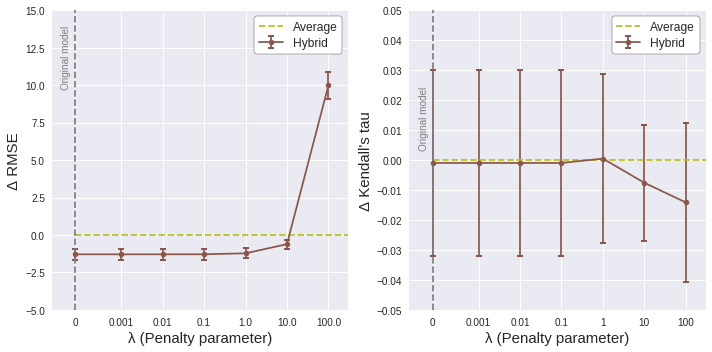

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Calculate alpha for 95% confidence interval for mean differences (n=10, 97.5% quantile=2.262 for 9 degree of freedom)
ci_multiplier = 2.262/sqrt(10)

# Set options for error bar and legends (wider spacing)
errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}
custom_opts = legend_opts.copy()
custom_opts['labelspacing'] = 0.3

# Plot differences in RMSE from baseline for both models
ax1.errorbar(hyb_lambda_df['lambda'], hyb_lambda_df['rmse_diff_avg'], 
             yerr=ci_multiplier*hyb_lambda_df['rmse_diff_std'],
           fmt='.-', color='tab:brown', label='Hybrid', **errorbar_opts)

ax1.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax1.axvline(0, ls='--', color='tab:gray')
ax1.text(-0.0003, 14, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax1.legend(loc='upper right', **custom_opts)

ax1.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax1.set_xscale('symlog', linthreshx=0.001)
ax1.set_xlim(-0.0005, 300)
ax1.set_xticklabels(lambda_values)

ax1.set_ylim(-5, 15)
ax1.set_ylabel('Δ RMSE', fontsize=15)

# Plot differences in Kendall's tau from baseline for both models
ax2.errorbar(hyb_lambda_df['lambda'], hyb_lambda_df['tau_diff_avg'], 
             yerr=ci_multiplier*hyb_lambda_df['tau_diff_std'],
           fmt='.-', color='tab:brown', label='Hybrid', **errorbar_opts)

ax2.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax2.text(-0.0003, 0.03-0.08*1/15, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax2.axvline(0, ls='--', color='tab:gray')
ax2.legend(loc='upper right', **custom_opts)

ax2.set_xscale('symlog', linthreshx=0.001)
ax2.set_xlim(-0.0005, 300)
ax2.set_xticklabels(lambda_values)
ax2.set_xticklabels([int(l) if l>=1 else l for l in lambda_values])
ax2.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax2.set_ylim(-0.05, 0.05)
ax2.set_yticks(np.arange(-0.05, 0.051, 0.01))
ax2.set_ylabel("Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

# fig.savefig('viz/hyb_diff_rmse_tau_lambda.png')

## Early stopping

Plot back iteration vs RMSE and Kendall's tau for male skaters in 2017 seson

In [46]:
# Calculate RMSE and tau for first 150 iterations of gradient descent
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd(season_scores, 
alpha=0.0005, n_iter=151, log_iter=True, log_every=1)

rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]
taus_log = [calculate_kendall_tau(season_ranking, world_ranking, verbose=False) for season_ranking in rankings_log]

# Calculate RMSE and tau for converged model (10000 iterations)
baseline_c, event_scores_c, skater_scores_c, rmse_c = batch_gd(season_scores, 
alpha=0.0005, n_iter=10000, return_rmse=True)
season_ranking_c, world_ranking_c = return_ranking(skater_scores_c, world_scores)
tau_c = calculate_kendall_tau(season_ranking_c, world_ranking_c, verbose=False)

Alpha: 0.0005, Iter: 151, Last RMSE: 8.86, Delta RMSE: -1.76e-08
Alpha: 0.0005, Iter: 10000, Last RMSE: 8.86, Delta RMSE: -1.7e-08


In [47]:
# The iteration where tau was the highest
where_max_tau = np.argmax(taus_log)
where_max_tau

22

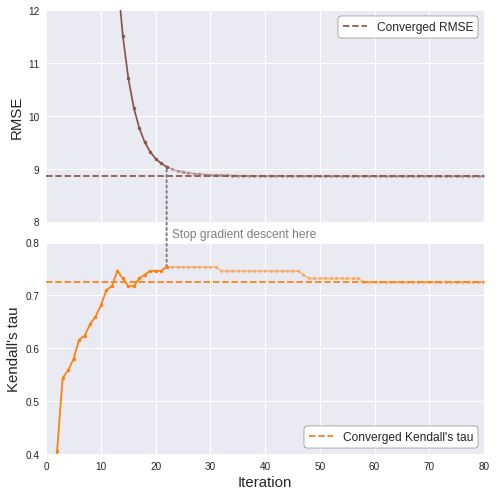

In [48]:
# Plot RMSE and Kendall's tau over iterations of gradient descent
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
ax1.plot(iter_log[:where_max_tau+1], rmse_log[:where_max_tau+1], '.-', color='tab:brown')
ax1.plot(iter_log[where_max_tau:], rmse_log[where_max_tau:], '.-', color='tab:brown', alpha=0.4)
ax1.axhline(rmse_c, ls='--', color='tab:brown', label='Converged RMSE')

ax1.legend(**legend_opts)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.set_ylim(8, 12)
ax1.set_yticks(range(8, 13))

ax2.plot(iter_log[:where_max_tau+1], taus_log[:where_max_tau+1], '.-', color='tab:orange')
ax2.plot(iter_log[where_max_tau:], taus_log[where_max_tau:], '.-', color='tab:orange', alpha=0.4)
ax2.axhline(tau_c, ls='--', color='tab:orange', label="Converged Kendall's tau")

ax2.legend(loc='lower right', **legend_opts)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.set_xlim(0, 80)
ax2.set_ylim(0.4, 0.8)
ax2.set_yticks(np.arange(0.4, 0.81, 0.1))
ax2.text(where_max_tau+1, 0.81, color='tab:gray', s='Stop gradient descent here', fontsize=12)

con = ConnectionPatch(xyA=(where_max_tau, taus_log[where_max_tau]), xyB=(where_max_tau, rmse_log[where_max_tau]), coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="tab:gray", lw=2, ls=':')
ax2.add_artist(con)


plt.tight_layout()
fig.savefig('viz/early_stop_vs_converged_2017.png')

Evaluate effect of early stopping for each year

In [49]:
# For each year, log values of tau, RMSE. concordant pairs for every iteration,
# and store them in a dict with the year as the key
taus_log_by_year = {}
rmse_log_by_year = {}
concords_log_by_year = {}

for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, season_train, world_train)
    baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd(season_scores, 
    alpha=0.0005, n_iter=200, log_iter=True, log_every=1)

    rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
    world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]
    
    taus_log = []
    concords_log = []
    pairs = []
    for season_ranking in rankings_log:        
        tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
        taus_log.append(tau)
        concords_log.append(concord)
        
    rmse_log_by_year[year] = rmse_log
    taus_log_by_year[year] = taus_log
    concords_log_by_year[year] = concords_log

2005
Alpha: 0.0005, Iter: 200, Last RMSE: 8.62, Delta RMSE: -5.139e-07
2006
Alpha: 0.0005, Iter: 200, Last RMSE: 7.95, Delta RMSE: -7.906e-07
2007
Alpha: 0.0005, Iter: 200, Last RMSE: 7.61, Delta RMSE: -1.81e-08
2009
Alpha: 0.0005, Iter: 200, Last RMSE: 8.18, Delta RMSE: -1.233e-07
2010
Alpha: 0.0005, Iter: 200, Last RMSE: 9.74, Delta RMSE: -6.93e-08
2012
Alpha: 0.0005, Iter: 200, Last RMSE: 8.31, Delta RMSE: -5.711e-07
2013
Alpha: 0.0005, Iter: 200, Last RMSE: 8.91, Delta RMSE: -3.135e-07
2014
Alpha: 0.0005, Iter: 200, Last RMSE: 8.8, Delta RMSE: -5.62e-08
2016
Alpha: 0.0005, Iter: 200, Last RMSE: 10.98, Delta RMSE: -5.56e-08
2017
Alpha: 0.0005, Iter: 200, Last RMSE: 8.86, Delta RMSE: -1.75e-08


In [50]:
# Convert relevant dicts to dataframe, with iteration as index, year as column
rmse_log_by_year = pd.DataFrame(rmse_log_by_year, index=iter_log)
taus_log_by_year = pd.DataFrame(taus_log_by_year, index=iter_log)
concords_log_by_year = pd.DataFrame(concords_log_by_year, index=iter_log)

In [51]:
# Calculate relevant metrics of baseline model of season average for each year
# and subtract them from those of the early stopping model
avg = AverageScore()
avg_df = avg.evaluate_over_years(train_years, season_train, world_train)

rmse_diffs_iter = rmse_log_by_year - avg_df['rmse'].values
tau_diffs_iter = taus_log_by_year - avg_df['tau'].values
concords_diffs_iter = concords_log_by_year - avg_df['conc'].values

In [52]:
# Which iteration has the highest Kendall's tau for each year
where_tau_max = taus_log_by_year.idxmax(axis=0)
where_tau_max

2005    34
2006    11
2007    39
2009    20
2010     7
2012    11
2013    25
2014    60
2016    14
2017    22
dtype: int64

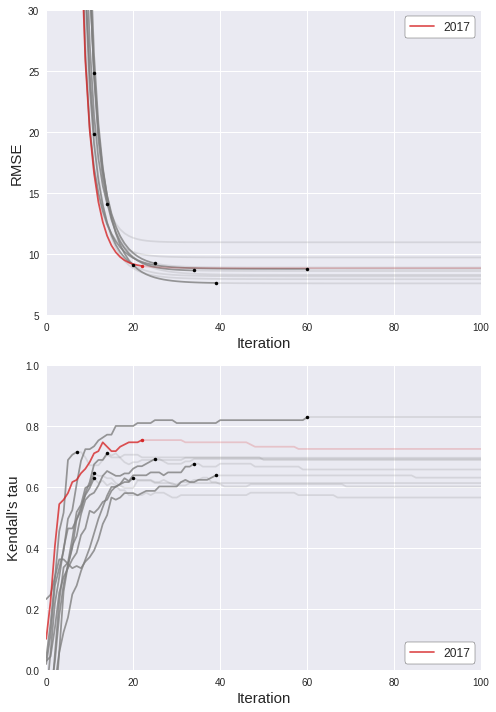

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))

# Plot RMSE for each iteration
for col in taus_log_by_year.columns:
    if col == 2017:
        ax1.plot(rmse_log_by_year.loc[:where_tau_max[col], col], color='tab:red', alpha=0.8, label='2017')
        ax1.plot(rmse_log_by_year.loc[where_tau_max[col]:, col], color='tab:red', alpha=0.2, label='_nolegend_')
    else:
        ax1.plot(rmse_log_by_year.loc[:where_tau_max[col], col], color='tab:gray', alpha=0.8, label='_nolegend_')
        ax1.plot(rmse_log_by_year.loc[where_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
for year, where in where_tau_max.iteritems():
    if year == 2017:
        ax1.plot(where, rmse_log_by_year.loc[where, year], '.', color='tab:red')
    else:
        ax1.plot(where, rmse_log_by_year.loc[where, year], '.', color='black')
ax1.legend(loc='upper right', **legend_opts)
ax1.set_xlim(0, 100)
ax1.set_ylim(5, 30)

ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel("RMSE", fontsize=15)

# Plot Kendall's tau for each iteration
for col in taus_log_by_year.columns:
    if col == 2017:
        ax2.plot(taus_log_by_year.loc[:where_tau_max[col], col], color='tab:red', alpha=0.8, label='2017')
        ax2.plot(taus_log_by_year.loc[where_tau_max[col]:, col], color='tab:red', alpha=0.2, label='_nolegend_')
    else:
        ax2.plot(taus_log_by_year.loc[:where_tau_max[col], col], color='tab:gray', alpha=0.8, label='_nolegend_')
        ax2.plot(taus_log_by_year.loc[where_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
for year, where in where_tau_max.iteritems():
    if year == 2017:
        ax2.plot(where, taus_log_by_year.loc[where, year], '.', color='tab:red')
    else:
        ax2.plot(where, taus_log_by_year.loc[where, year], '.', color='black')
ax2.legend(loc='lower right', **legend_opts)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 1)

ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)

plt.tight_layout()

fig.savefig('viz/earlystop_iter_rmse_tau.png')

Find ideal stopping point for all years on average

In [54]:
# At which iteration is the average Kendall's tau difference to baseline is the highest
where_tau_diff_max = tau_diffs_iter.mean(axis=1).idxmax()
where_tau_diff_max

47

In [55]:
# The mean and std Kendall's tau difference to baseline at this ideal stopping point
max_tau_diff_mean, max_tau_diff_std = tau_diffs_iter.loc[where_tau_diff_max].mean(), tau_diffs_iter.loc[where_tau_diff_max].std()
max_tau_diff_mean, max_tau_diff_std

(0.005341614906832303, 0.04371524068084949)

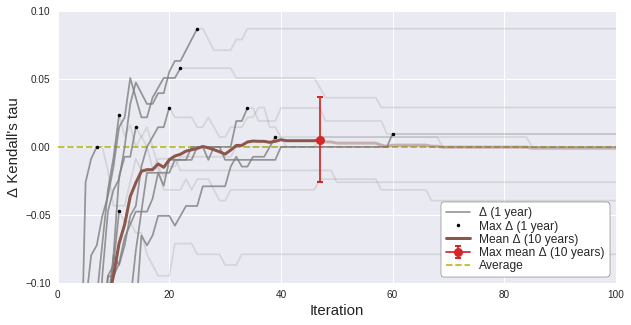

In [56]:
# Plot average difference in Kendall's tau to baseline for each iteration
fig, ax = plt.subplots(figsize=(10, 5))
errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}
ci_multiplier = 2.262/sqrt(10)

ax.hlines(0, 0, 100, linestyles='--', color='tab:olive', label='Average')
for col in tau_diffs_iter.columns:
    if col == 2017:
        ax.plot(tau_diffs_iter.loc[:where_tau_max[col], col], color='tab:gray', alpha=0.8, label='Δ (1 year)')
        ax.plot(tau_diffs_iter.loc[where_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
    else:
        ax.plot(tau_diffs_iter.loc[:where_tau_max[col], col], color='tab:gray', alpha=0.8, label='_nolegend_')
        ax.plot(tau_diffs_iter.loc[where_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
for year, where in where_tau_max.iteritems():
    if year == 2017:
        ax.plot(where, tau_diffs_iter.loc[where, year], '.', color='black', label='Max Δ (1 year)')
    else:
        ax.plot(where, tau_diffs_iter.loc[where, year], '.', color='black', label='_nolegend_')
        
ax.plot(tau_diffs_iter.mean(axis=1)[:where_tau_diff_max+1], lw=3, color='tab:brown', label='Mean Δ (10 years)')
ax.plot(tau_diffs_iter.mean(axis=1)[where_tau_diff_max:], lw=3, color='tab:brown', alpha=0.4, label='_nolegend_')

ax.errorbar(where_tau_diff_max, max_tau_diff_mean, 
             yerr=ci_multiplier*max_tau_diff_std,
           fmt='o-', color='tab:red', label='Max mean Δ (10 years)', zorder=10, **errorbar_opts)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:-2]+[handles[4]]+[handles[3]],
          labels[:-2]+[labels[4]]+[labels[3]], loc='lower right', **legend_opts)

ax.set_xlim(0, 100)
ax.set_ylim(-0.1, 0.1)
ax.set_yticks(np.arange(-0.1, 0.101, 0.05))

ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel("Δ Kendall's tau", fontsize=15)
fig.savefig('viz/earlystop_iter_tau_diff.png')

## Combine model penalization with early stopping

In [57]:
avg = AverageScore()
avg_df = avg.evaluate_over_years(train_years, season_train, world_train)

In [58]:
results_lambda = pd.DataFrame(columns=['rmse_diff_mean', 'rmse_diff_std',
                                 'tau_diff_mean', 'tau_diff_std',
                                 'concord_diff_mean', 'concord_diff_std', 'lambda', 'iter'])

for lambda_param in lambda_values:
    print(f'lambda: {lambda_param}------')
    taus_log_by_year = {}
    rmse_log_by_year = {}
    concords_log_by_year = {}
    pairs_by_year = {}

    for year in train_years:
        print(f'year: {year}')
        season_scores, world_scores = get_yearly_scores(year, season_train, world_train)
        baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd_penalized(season_scores, 
        alpha=0.0005, lambda_param=lambda_param, n_iter=101, log_iter=True, log_every=1)

        rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
        world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]

        taus_log = []
        concords_log = []
        pairs = []
        for season_ranking in rankings_log:        
            tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
            taus_log.append(tau)
            concords_log.append(concord)

        rmse_log_by_year[year] = rmse_log
        taus_log_by_year[year] = taus_log
        concords_log_by_year[year] = concords_log
    
    # For each lambda value, calculate mean and std of difference in RMSE and Kendall's tau to baseline at each iteration
    rmse_log_by_year = pd.DataFrame(rmse_log_by_year, index=iter_log)
    taus_log_by_year = pd.DataFrame(taus_log_by_year, index=iter_log)
    concords_log_by_year = pd.DataFrame(concords_log_by_year, index=iter_log)
    
    rmse_diffs_iter = rmse_log_by_year - avg_df['rmse'].values
    tau_diffs_iter = taus_log_by_year - avg_df['tau'].values
    concords_diffs_iter = concords_log_by_year - avg_df['conc'].values
    
    rmse_diff_mean, rmse_diff_std = rmse_diffs_iter.mean(axis=1), rmse_diffs_iter.std(axis=1)
    tau_diff_mean, tau_diff_std = tau_diffs_iter.mean(axis=1), tau_diffs_iter.std(axis=1)
    concord_diff_mean, concord_diff_std = concords_diffs_iter.mean(axis=1), concords_diffs_iter.std(axis=1)
    
    result_lambda = pd.concat([rmse_diff_mean, rmse_diff_std, tau_diff_mean, tau_diff_std, concord_diff_mean, concord_diff_std], axis=1,
                           keys=['rmse_diff_mean', 'rmse_diff_std',
                                 'tau_diff_mean', 'tau_diff_std',
                                 'concord_diff_mean', 'concord_diff_std'])
    result_lambda['lambda'] = lambda_param
    result_lambda['iter'] = iter_log
    
    # Concatenate data for all lambdas and iterations into one datatable (long format, not pivot)
    results_lambda = pd.concat([results_lambda, result_lambda], axis=0)

lambda: 0------
year: 2005
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.63, Delta RMSE: -1.6325e-06
year: 2006
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 7.95, Delta RMSE: -6.6241e-06
year: 2007
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 7.61, Delta RMSE: -1.03337e-05
year: 2009
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.18, Delta RMSE: -5.636e-07
year: 2010
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 9.74, Delta RMSE: -3.913e-07
year: 2012
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.31, Delta RMSE: -7.483e-07
year: 2013
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.91, Delta RMSE: -4.585e-07
year: 2014
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.8, Delta RMSE: -1.2136e-06
year: 2016
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 10.98, Delta RMSE: -6.31e-08
year: 2017
Alpha: 0.0005, Lambda: 0, Iter: 101, Last RMSE: 8.86, Delta RMSE: -1.826e-07
lambda: 0.001------
year: 2005
Alpha: 0.0005, Lambda: 0.001, Iter: 101, Last RMSE: 8.63, Delta RMSE:

In [59]:
# Create pivot table of mean and std difference for Kendall's tau (index=lambdas, column=iterations)
tau_diff_mean_pivot = pd.pivot_table(results_lambda[['iter', 'lambda', 'tau_diff_mean']], values='tau_diff_mean', index='lambda', columns='iter')
tau_diff_std_pivot = pd.pivot_table(results_lambda[['iter', 'lambda', 'tau_diff_std']], values='tau_diff_std', index='lambda', columns='iter')

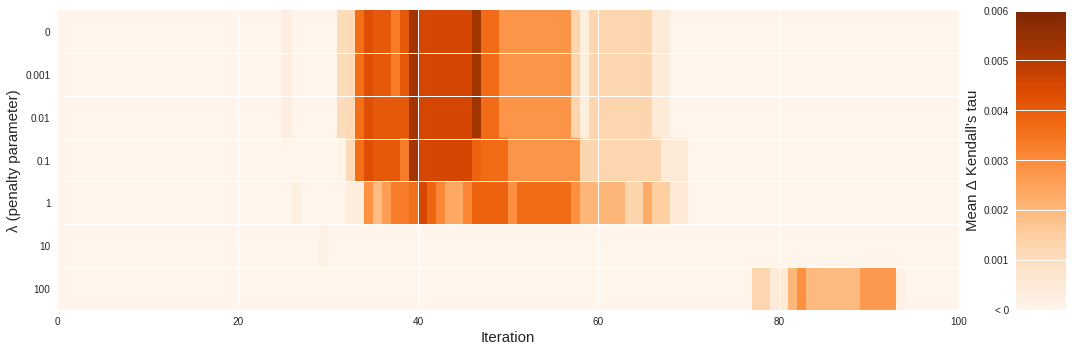

In [78]:
# Use pivot table for mean difference in Kendall's tau to plot heatmap for each combination lambda and iteration 
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(1, 10)
ax = fig.add_subplot(grid[:, :-1])
ax.imshow(tau_diff_mean_pivot, cmap='Oranges', vmin=0, vmax=0.006, aspect='auto')

ax.set_xlim(0.5, 99.5)
ax.set_xticks(np.arange(0, 101, 20)+0.5)
ax.set_xticklabels(np.arange(0, 101, 20))
ax.set_xlabel('Iteration', fontsize=15)
ax.set_yticks(np.arange(len(lambda_values)))
ax.set_yticklabels([int(v) if v>=1 else v for v in lambda_values])
ax.set_ylabel('λ (penalty parameter)', fontsize=15)
for i in range(0, 101, 20):
    ax.axvline(i+0.5, lw=1, color='white')
for j in range(len(lambda_values)):
    ax.axhline(j+0.5, lw=1, color='white')
ax.grid(None)

axc = fig.add_subplot(grid[:, -1])
cmap = plt.cm.get_cmap('Oranges')
colors = cmap(np.arange(cmap.N, -1, -1))
axc.imshow(colors[:, np.newaxis, :], extent=[0, 0.001, 0, 0.006])
axc.set_ylabel("Mean Δ Kendall's tau", fontsize=15)
axc.set_xticks([])
axc.set_yticklabels(['< 0', '0.001', '0.002', '0.003', '0.004', '0.005', '0.006'])

plt.tight_layout()
plt.show()

fig.savefig('viz/male_iteration_lambda_heatmap.png')

In [61]:
# For each lambda, at which iteration is the difference in Kendall's tau to baseline the highest
where_max_tau_diff = tau_diff_mean_pivot.idxmax(axis=1)
max_tau_diff = tau_diff_mean_pivot.max(axis=1)
male_tau_diff = pd.concat([where_max_tau_diff, max_tau_diff], axis=1, keys=['where', 'tau_diff_avg'])
male_tau_diff

,where,tau_diff_avg
lambda,,
0.000,47,0.005342
0.001,47,0.005342
0.010,47,0.005342
0.100,40,0.005276
1.000,41,0.004551
10.000,30,0.000149
100.000,83,0.002927


In [62]:
# Add in std, upper and lower 95% confidence interval for the ideal stoppping point at each lambda
for lambda_param, where in where_max_tau_diff.iteritems():
    male_tau_diff.loc[lambda_param, 'tau_diff_std'] = tau_diff_std_pivot.loc[lambda_param, where]
male_tau_diff['tau_diff_lower'] = male_tau_diff['tau_diff_avg'] - ci_multiplier * male_tau_diff['tau_diff_std']
male_tau_diff['tau_diff_upper'] = male_tau_diff['tau_diff_avg'] + ci_multiplier * male_tau_diff['tau_diff_std']
male_tau_diff['lambda'] = lambda_values
male_tau_diff

,where,tau_diff_avg,tau_diff_std,tau_diff_lower,tau_diff_upper,lambda
lambda,,,,,,
0.000,47,0.005342,0.043715,-0.025928,0.036611,0.000
0.001,47,0.005342,0.043715,-0.025928,0.036611,0.001
0.010,47,0.005342,0.043715,-0.025928,0.036611,0.010
0.100,40,0.005276,0.045125,-0.027002,0.037554,0.100
1.000,41,0.004551,0.045406,-0.027928,0.037030,1.000
10.000,30,0.000149,0.042907,-0.030543,0.030840,10.000
100.000,83,0.002927,0.032753,-0.020502,0.026355,100.000


In [93]:
results_lambda.loc[(results_lambda['lambda']==0) & (results_lambda['iter']==47)]

,rmse_diff_mean,rmse_diff_std,tau_diff_mean,tau_diff_std,concord_diff_mean,concord_diff_std,lambda,iter
47,-1.285604,0.514407,0.005342,0.043715,0.7,5.538752,0,47


## Do the same for female skaters

In [63]:
fseason_train, fworld_train, fseason_test, fworld_test = train_test_split(female_scores, train_years, test_years)
fseason_train.shape, fworld_train.shape, fseason_test.shape, fworld_test.shape

((1220, 4), (239, 4), (507, 4), (95, 4))

### Early stopping

In [64]:
ftaus_log_by_year = {}
frmse_log_by_year = {}
fconcords_log_by_year = {}

for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, fseason_train, fworld_train)
    baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd(season_scores, 
    alpha=0.0005, n_iter=200, log_iter=True, log_every=1)

    rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
    world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]
    
    taus_log = []
    concords_log = []
    pairs = []
    for season_ranking in rankings_log:        
        tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
        taus_log.append(tau)
        concords_log.append(concord)
        
    frmse_log_by_year[year] = rmse_log
    ftaus_log_by_year[year] = taus_log
    fconcords_log_by_year[year] = concords_log

2005
Alpha: 0.0005, Iter: 200, Last RMSE: 6.29, Delta RMSE: -6.154e-07
2006
Alpha: 0.0005, Iter: 200, Last RMSE: 6.62, Delta RMSE: -3.0635e-06
2007
Alpha: 0.0005, Iter: 200, Last RMSE: 6.38, Delta RMSE: -1.683e-07
2009
Alpha: 0.0005, Iter: 200, Last RMSE: 5.45, Delta RMSE: -5.797e-07
2010
Alpha: 0.0005, Iter: 200, Last RMSE: 6.73, Delta RMSE: -7.807e-07
2012
Alpha: 0.0005, Iter: 200, Last RMSE: 5.58, Delta RMSE: -2.768e-07
2013
Alpha: 0.0005, Iter: 200, Last RMSE: 4.95, Delta RMSE: -3.059e-07
2014
Alpha: 0.0005, Iter: 200, Last RMSE: 6.26, Delta RMSE: -1.7e-09
2016
Alpha: 0.0005, Iter: 200, Last RMSE: 6.24, Delta RMSE: -1.742e-07
2017
Alpha: 0.0005, Iter: 200, Last RMSE: 6.19, Delta RMSE: -1.14e-07


In [65]:
# Calculate relevant metrics of baseline model of season average for each year
# and subtract them from those of the early stopping model
favg = AverageScore()
favg_df = avg.evaluate_over_years(train_years, fseason_train, fworld_train)

frmse_log_by_year = pd.DataFrame(frmse_log_by_year, index=iter_log)
ftaus_log_by_year = pd.DataFrame(ftaus_log_by_year, index=iter_log)
fconcords_log_by_year = pd.DataFrame(fconcords_log_by_year, index=iter_log)

frmse_diffs_iter = frmse_log_by_year - favg_df['rmse'].values
ftau_diffs_iter = ftaus_log_by_year - favg_df['tau'].values
fconcords_diffs_iter = fconcords_log_by_year - favg_df['conc'].values

In [66]:
# For each year, at which iteration is the Kendall's tau is the highest
fwhere_tau_max = ftaus_log_by_year.idxmax(axis=0)
fwhere_tau_max

2005    10
2006    30
2007    33
2009    44
2010    44
2012    13
2013    34
2014    29
2016    33
2017    21
dtype: int64

In [67]:
# Averaged over 10 years, at which iteration is the average Kendall's tau difference to baseline is the highest
fwhere_tau_diff_max = ftau_diffs_iter.mean(axis=1).idxmax()
fwhere_tau_diff_max

41

In [68]:
# The average and std Kendall's tau difference to baseline at that ideal stopping point
fmax_tau_diff_mean, fmax_tau_diff_std = ftau_diffs_iter.loc[fwhere_tau_diff_max].mean(), ftau_diffs_iter.loc[fwhere_tau_diff_max].std()
fmax_tau_diff_mean, fmax_tau_diff_std

(0.009472990777338552, 0.021960563947724623)

Text(0,0.5,"Δ Kendall's tau")

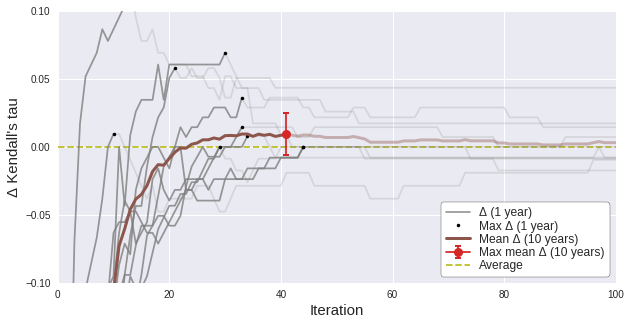

In [69]:
# Plot average difference in Kendall's tau to baseline for each iteration
fig, ax = plt.subplots(figsize=(10, 5))
errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}
ci_multiplier = 2.262/sqrt(10)

ax.hlines(0, 0, 100, linestyles='--', color='tab:olive', label='Average')
for col in tau_diffs_iter.columns:
    if col == 2017:
        l2 = ax.plot(ftau_diffs_iter.loc[:fwhere_tau_max[col], col], color='tab:gray', alpha=0.8, label='Δ (1 year)')
        ax.plot(ftau_diffs_iter.loc[fwhere_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
    else:
        ax.plot(ftau_diffs_iter.loc[:fwhere_tau_max[col], col], color='tab:gray', alpha=0.8, label='_nolegend_')
        ax.plot(ftau_diffs_iter.loc[fwhere_tau_max[col]:, col], color='tab:gray', alpha=0.2, label='_nolegend_')
for year, where in fwhere_tau_max.iteritems():
    if year == 2017:
        l3 = ax.plot(where, ftau_diffs_iter.loc[where, year], '.', color='black', label='Max Δ (1 year)')
    else:
        ax.plot(where, ftau_diffs_iter.loc[where, year], '.', color='black', label='_nolegend_')
        
ax.plot(ftau_diffs_iter.mean(axis=1)[:fwhere_tau_diff_max+1], lw=3, color='tab:brown', label='Mean Δ (10 years)')
ax.plot(ftau_diffs_iter.mean(axis=1)[fwhere_tau_diff_max:], lw=3, color='tab:brown', alpha=0.4, label='_nolegend_')

ax.errorbar(fwhere_tau_diff_max, fmax_tau_diff_mean, 
             yerr=ci_multiplier*fmax_tau_diff_std,
           fmt='o-', color='tab:red', label='Max mean Δ (10 years)', zorder=10, **errorbar_opts)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:-2]+[handles[4]]+[handles[3]],
          labels[:-2]+[labels[4]]+[labels[3]], loc='lower right', **legend_opts)

ax.set_xlim(0, 100)
ax.set_ylim(-0.10, 0.10)
ax.set_yticks(np.arange(-0.1, 0.141, 0.05))

ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel("Δ Kendall's tau", fontsize=15)

### Model penalization

In [70]:
# Store changes against lambda for each year inside a dict, where the keys are the year numbers
ftaus_lambda_by_year = {}
frmses_lambda_by_year = {}
fconcords_lambda_by_year = {}
fpairs_by_year = {}

# Repeat the same evaluation as 2017 (by varying lambda) for all 10 years in the training set
for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, fseason_train, fworld_train)

    skater_scores_lambda = []
    rmses_lambda = []

    for lambda_param in lambda_values:
        baseline, event_scores, skater_scores, rmse = batch_gd_penalized(season_scores,
                                                                   alpha=0.0005, n_iter=10000, lambda_param=lambda_param,
                                                                   return_rmse=True)
        skater_scores_lambda.append(skater_scores)
        rmses_lambda.append(rmse)
        
    frmses_lambda_by_year[year] = rmses_lambda
    rankings_lambda = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_lambda]
    world_ranking = return_ranking(skater_scores_lambda[0], world_scores)[1]
    
    taus_lambda = []
    concords_lambda = []    
    for season_ranking in rankings_lambda:        
        tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
        taus_lambda.append(tau)
        concords_lambda.append(concord)
    
    # Store taus, concordant pairs, and number of pairs against lambda for a given year in the respective dict,
    # with the year as key
    ftaus_lambda_by_year[year] = taus_lambda    
    fconcords_lambda_by_year[year] = concords_lambda
    fpairs_by_year[year] = pair
    
    
# Convert relevant dicts into DataFrame with lambda as index, and year as column
ftaus_lambda_by_year = pd.DataFrame(ftaus_lambda_by_year, index=lambda_values)
frmses_lambda_by_year = pd.DataFrame(frmses_lambda_by_year, index=lambda_values)
fconcords_lambda_by_year = pd.DataFrame(fconcords_lambda_by_year, index=lambda_values)

# Calculate yearly difference in tau, RMSE, and number of concordant pairs
# over the baseline model for each value of lambda
ftau_diffs_lambda = ftaus_lambda_by_year - favg_df['tau'].values
frmse_diffs_lambda = frmses_lambda_by_year - favg_df['rmse'].values
fconc_diffs_lambda = fconcords_lambda_by_year - favg_df['conc'].values

# Calculate mean and std (for condifence interval) of difference in RMSE and tau for each value of lambda
fhyb_lambda_df = pd.concat([frmse_diffs_lambda.mean(axis=1),
           frmse_diffs_lambda.std(axis=1),
           ftau_diffs_lambda.mean(axis=1),
           ftau_diffs_lambda.std(axis=1)], axis=1)
fhyb_lambda_df.columns = ['rmse_diff_avg', 'rmse_diff_std',
                         'tau_diff_avg', 'tau_diff_std']
fhyb_lambda_df['lambda'] = lambda_values

2005
Alpha: 0.0005, Lambda: 0, Iter: 10000, Last RMSE: 6.28, Delta RMSE: -7.09e-07
Alpha: 0.0005, Lambda: 0.001, Iter: 10000, Last RMSE: 6.28, Delta RMSE: -7.251e-07
Alpha: 0.0005, Lambda: 0.01, Iter: 10000, Last RMSE: 6.28, Delta RMSE: -8.726e-07
Alpha: 0.0005, Lambda: 0.1, Iter: 10000, Last RMSE: 6.27, Delta RMSE: -2.6075e-06
Alpha: 0.0005, Lambda: 1.0, Iter: 10000, Last RMSE: 6.23, Delta RMSE: 3.9654e-06
Alpha: 0.0005, Lambda: 10.0, Iter: 10000, Last RMSE: 6.83, Delta RMSE: 0.0
Alpha: 0.0005, Lambda: 100.0, Iter: 10000, Last RMSE: 18.49, Delta RMSE: 0.0
2006
Alpha: 0.0005, Lambda: 0, Iter: 10000, Last RMSE: 6.62, Delta RMSE: -3.648e-07
Alpha: 0.0005, Lambda: 0.001, Iter: 10000, Last RMSE: 6.62, Delta RMSE: -3.577e-07
Alpha: 0.0005, Lambda: 0.01, Iter: 10000, Last RMSE: 6.62, Delta RMSE: -2.914e-07
Alpha: 0.0005, Lambda: 0.1, Iter: 10000, Last RMSE: 6.63, Delta RMSE: 5.611e-07
Alpha: 0.0005, Lambda: 1.0, Iter: 10000, Last RMSE: 6.8, Delta RMSE: 8.912e-06
Alpha: 0.0005, Lambda: 10.0, 

In [86]:
fhyb_lambda_df

,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std,lambda
0.000,-1.131755,0.729093,0.003047,0.019040,0.000
0.001,-1.131788,0.729129,0.003047,0.019040,0.001
0.010,-1.132089,0.729452,0.003047,0.019040,0.010
0.100,-1.135126,0.732484,0.001466,0.019605,0.100
1.000,-1.142550,0.708060,-0.000327,0.020453,1.000
10.000,-0.561302,0.673279,-0.002144,0.021355,10.000
100.000,11.087803,1.256655,-0.017470,0.040607,100.000


In [94]:
fhyb_lambda_df['tau_diff_avg'] - ci_multiplier * fhyb_lambda_df['tau_diff_std']

0.000     -0.010572
0.001     -0.010572
0.010     -0.010572
0.100     -0.012557
1.000     -0.014958
10.000    -0.017419
100.000   -0.046517
dtype: float64

In [95]:
fhyb_lambda_df['tau_diff_avg'] + ci_multiplier * fhyb_lambda_df['tau_diff_std']

0.000      0.016667
0.001      0.016667
0.010      0.016667
0.100      0.015489
1.000      0.014303
10.000     0.013131
100.000    0.011576
dtype: float64

### Early stopping + Model penalization

In [71]:
fresults_lambda = pd.DataFrame(columns=['rmse_diff_mean', 'rmse_diff_std',
                                 'tau_diff_mean', 'tau_diff_std',
                                 'concord_diff_mean', 'concord_diff_std', 'lambda', 'iter'])

for lambda_param in lambda_values:
    print(f'lambda: {lambda_param}------')
    taus_log_by_year = {}
    rmse_log_by_year = {}
    concords_log_by_year = {}
    pairs_by_year = {}

    for year in train_years:
        print(f'year: {year}')
        season_scores, world_scores = get_yearly_scores(year, fseason_train, fworld_train)
        baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd_penalized(season_scores, 
        alpha=0.0005, lambda_param=lambda_param, n_iter=201, log_iter=True, log_every=1)

        rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
        world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]

        taus_log = []
        concords_log = []
        pairs = []
        for season_ranking in rankings_log:        
            tau, concord, pair = calculate_kendall_tau(season_ranking, world_ranking, verbose=False, return_pairs=True)
            taus_log.append(tau)
            concords_log.append(concord)

        rmse_log_by_year[year] = rmse_log
        taus_log_by_year[year] = taus_log
        concords_log_by_year[year] = concords_log
    
    # For each lambda value, calculate mean and std of difference in RMSE and Kendall's tau to baseline at each iteration
    rmse_log_by_year = pd.DataFrame(rmse_log_by_year, index=iter_log)
    taus_log_by_year = pd.DataFrame(taus_log_by_year, index=iter_log)
    concords_log_by_year = pd.DataFrame(concords_log_by_year, index=iter_log)
    
    rmse_diffs_iter = rmse_log_by_year - favg_df['rmse'].values
    tau_diffs_iter = taus_log_by_year - favg_df['tau'].values
    concords_diffs_iter = concords_log_by_year - favg_df['conc'].values
    
    rmse_diff_mean, rmse_diff_std = rmse_diffs_iter.mean(axis=1), rmse_diffs_iter.std(axis=1)
    tau_diff_mean, tau_diff_std = tau_diffs_iter.mean(axis=1), tau_diffs_iter.std(axis=1)
    concord_diff_mean, concord_diff_std = concords_diffs_iter.mean(axis=1), concords_diffs_iter.std(axis=1)
    
    fresult_lambda = pd.concat([rmse_diff_mean, rmse_diff_std, tau_diff_mean, tau_diff_std, concord_diff_mean, concord_diff_std], axis=1,
                           keys=['rmse_diff_mean', 'rmse_diff_std',
                                 'tau_diff_mean', 'tau_diff_std',
                                 'concord_diff_mean', 'concord_diff_std'])
    fresult_lambda['lambda'] = lambda_param
    fresult_lambda['iter'] = iter_log
    
    # Concatenate data for all lambdas and iterations into one datatable (long format, not pivot)
    fresults_lambda = pd.concat([fresults_lambda, fresult_lambda], axis=0)

lambda: 0------
year: 2005
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.29, Delta RMSE: -6.124e-07
year: 2006
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.62, Delta RMSE: -2.951e-06
year: 2007
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.38, Delta RMSE: -1.66e-07
year: 2009
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 5.45, Delta RMSE: -5.796e-07
year: 2010
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.73, Delta RMSE: -7.807e-07
year: 2012
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 5.58, Delta RMSE: -2.764e-07
year: 2013
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 4.95, Delta RMSE: -2.968e-07
year: 2014
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.26, Delta RMSE: -1.7e-09
year: 2016
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.24, Delta RMSE: -1.728e-07
year: 2017
Alpha: 0.0005, Lambda: 0, Iter: 201, Last RMSE: 6.19, Delta RMSE: -1.138e-07
lambda: 0.001------
year: 2005
Alpha: 0.0005, Lambda: 0.001, Iter: 201, Last RMSE: 6.29, Delta RMSE: -6.252

In [72]:
# Create pivot table of mean and std difference for Kendall's tau (index=lambdas, column=iterations)
ftau_diff_mean_pivot = pd.pivot_table(fresults_lambda[['iter', 'lambda', 'tau_diff_mean']], values='tau_diff_mean', index='lambda', columns='iter')
ftau_diff_std_pivot = pd.pivot_table(fresults_lambda[['iter', 'lambda', 'tau_diff_std']], values='tau_diff_std', index='lambda', columns='iter')

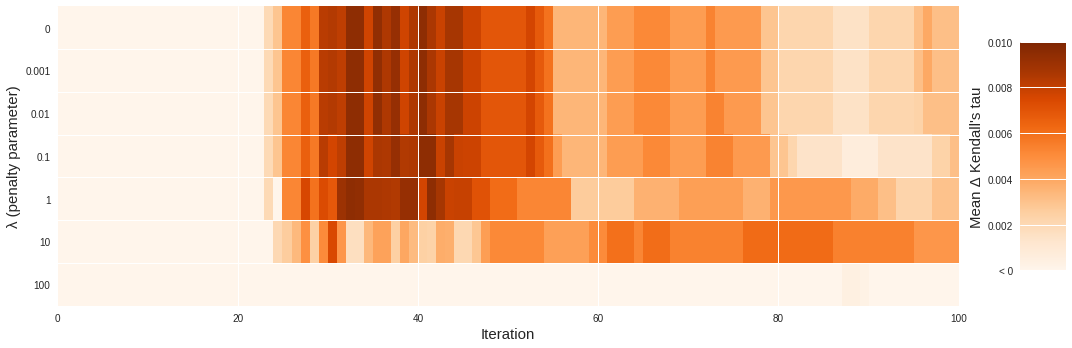

In [73]:
# Use pivot table for mean difference in Kendall's tau to plot heatmap for each combination lambda and iteration 
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(1, 10)
ax = fig.add_subplot(grid[:, :-1])
ax.imshow(ftau_diff_mean_pivot, cmap='Oranges', vmin=0, vmax=0.01, aspect='auto')

ax.set_xlim(0.5, 100)
ax.set_xticks(np.arange(0, 101, 20)+0.5)
ax.set_xticklabels(np.arange(0, 101, 20))
ax.set_xlabel('Iteration', fontsize=15)
ax.set_yticks(np.arange(len(lambda_values)))
ax.set_yticklabels([int(v) if v>=1 else v for v in lambda_values])
ax.set_ylabel('λ (penalty parameter)', fontsize=15)
for i in range(0, 101, 20):
    ax.axvline(i+0.5, lw=1, color='white')
for j in range(len(lambda_values)):
    ax.axhline(j+0.5, lw=1, color='white')
ax.grid(None)

axc = fig.add_subplot(grid[:, -1])
cmap = plt.cm.get_cmap('Oranges')
colors = cmap(np.arange(cmap.N, -1, -1))
axc.imshow(colors[:, np.newaxis, :], extent=[0, 0.002, 0, 0.01])
axc.set_ylabel("Mean Δ Kendall's tau", fontsize=15)
axc.set_xticks([])
axc.set_yticklabels(['< 0', '0.002', '0.004', '0.006', '0.008', '0.010'])

plt.tight_layout()
plt.show()

In [74]:
# For each lambda, at which iteration is the difference in Kendall's tau to baseline the highest
fwhere_max_tau_diff = ftau_diff_mean_pivot.idxmax(axis=1)
fmax_tau_diff = ftau_diff_mean_pivot.max(axis=1)
female_tau_diff = pd.concat([fwhere_max_tau_diff, fmax_tau_diff], axis=1, keys=['where', 'tau_diff_avg'])
female_tau_diff

,where,tau_diff_avg
lambda,,
0.000,41,0.009473
0.001,41,0.009473
0.010,41,0.009473
0.100,41,0.009473
1.000,42,0.009473
10.000,31,0.007457
100.000,131,0.004417


In [75]:
# Add in std, upper and lower 95% confidence interval for the ideal stoppping point at each lambda
for lambda_param, where in fwhere_max_tau_diff.iteritems():
    female_tau_diff.loc[lambda_param, 'tau_diff_std'] = ftau_diff_std_pivot.loc[lambda_param, where]
female_tau_diff['tau_diff_lower'] = female_tau_diff['tau_diff_avg'] - ci_multiplier * female_tau_diff['tau_diff_std']
female_tau_diff['tau_diff_upper'] = female_tau_diff['tau_diff_avg'] + ci_multiplier * female_tau_diff['tau_diff_std']
female_tau_diff['lambda'] = lambda_values
female_tau_diff

,where,tau_diff_avg,tau_diff_std,tau_diff_lower,tau_diff_upper,lambda
lambda,,,,,,
0.000,41,0.009473,0.021961,-0.006236,0.025182,0.000
0.001,41,0.009473,0.021961,-0.006236,0.025182,0.001
0.010,41,0.009473,0.021961,-0.006236,0.025182,0.010
0.100,41,0.009473,0.021961,-0.006236,0.025182,0.100
1.000,42,0.009473,0.021961,-0.006236,0.025182,1.000
10.000,31,0.007457,0.036793,-0.018861,0.033775,10.000
100.000,131,0.004417,0.034753,-0.020441,0.029276,100.000


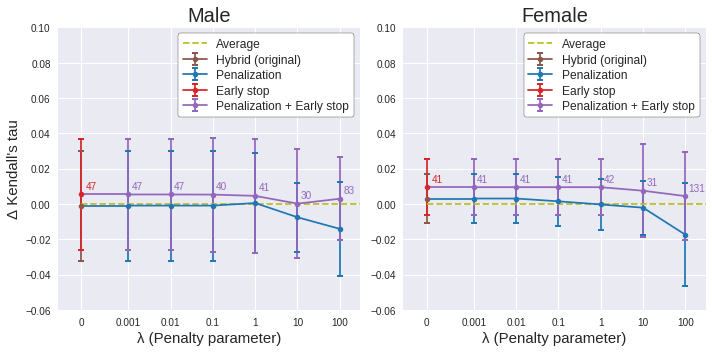

In [80]:
fig, (axm, axf) = plt.subplots(1, 2, figsize=(10, 5))

# Plot differences in Kendall's tau from baseline for all models (male skaters)
axm.errorbar(hyb_lambda_df['lambda'].iloc[0], hyb_lambda_df['tau_diff_avg'].iloc[0], 
             yerr=ci_multiplier*hyb_lambda_df['tau_diff_std'].iloc[0],
           fmt='.-', color='tab:brown', label='Hybrid (original)', **errorbar_opts)
axm.plot(hyb_lambda_df['lambda'].iloc[[0, 1]], hyb_lambda_df['tau_diff_avg'].iloc[[0, 1]], color='tab:blue', label='_nolegend_')
axm.errorbar(hyb_lambda_df['lambda'].iloc[1:], hyb_lambda_df['tau_diff_avg'].iloc[1:], 
             yerr=ci_multiplier*hyb_lambda_df['tau_diff_std'].iloc[1:],
           fmt='.-', color='tab:blue', label='Penalization', **errorbar_opts)
axm.errorbar(male_tau_diff['lambda'].iloc[0], male_tau_diff['tau_diff_avg'].iloc[0], 
             yerr=ci_multiplier*male_tau_diff['tau_diff_std'].iloc[0],
           fmt='.-', color='tab:red', label='Early stop', **errorbar_opts)
axm.errorbar(male_tau_diff['lambda'].iloc[1:], male_tau_diff['tau_diff_avg'].iloc[1:], 
             yerr=ci_multiplier*male_tau_diff['tau_diff_std'].iloc[1:],
           fmt='.-', color='tab:purple', label='Penalization + Early stop', **errorbar_opts)
axm.plot(male_tau_diff['lambda'].iloc[[0, 1]], male_tau_diff['tau_diff_avg'].iloc[[0, 1]], color='tab:purple', label='_nolegend_')
axm.text(0.0001, male_tau_diff.loc[0, 'tau_diff_avg']+0.003, s=male_tau_diff.loc[0, 'where'], color='tab:red')
for lambda_param, row in male_tau_diff.iloc[1:].iterrows():
    axm.text(lambda_param*1.2, row['tau_diff_avg']+0.003, s=int(row['where']), color='tab:purple')

axm.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
axm.legend(loc='upper right', **custom_opts)

axm.set_xscale('symlog', linthreshx=0.001)
axm.set_xlim(-0.0005, 300)
axm.set_xticklabels(lambda_labels)
axm.set_xlabel('λ (Penalty parameter)', fontsize=15)
axm.set_ylim(-0.06, 0.1)
axm.set_yticks(np.arange(-0.06, 0.11, 0.02))
axm.set_ylabel("Δ Kendall's tau", fontsize=15)
axm.set_title('Male', fontsize=20)

# Plot differences in Kendall's tau from baseline for all models (female skaters)
axf.errorbar(fhyb_lambda_df['lambda'].iloc[0], fhyb_lambda_df['tau_diff_avg'].iloc[0], 
             yerr=ci_multiplier*fhyb_lambda_df['tau_diff_std'].iloc[0],
           fmt='.-', color='tab:brown', label='Hybrid (original)', **errorbar_opts)
axf.plot(fhyb_lambda_df['lambda'].iloc[[0, 1]], fhyb_lambda_df['tau_diff_avg'].iloc[[0, 1]], color='tab:blue', label='_nolegend_')
axf.errorbar(fhyb_lambda_df['lambda'].iloc[1:], fhyb_lambda_df['tau_diff_avg'].iloc[1:], 
             yerr=ci_multiplier*fhyb_lambda_df['tau_diff_std'].iloc[1:],
           fmt='.-', color='tab:blue', label='Penalization', **errorbar_opts)
axf.errorbar(female_tau_diff['lambda'].iloc[0], female_tau_diff['tau_diff_avg'].iloc[0], 
             yerr=ci_multiplier*female_tau_diff['tau_diff_std'].iloc[0],
           fmt='.-', color='tab:red', label='Early stop', **errorbar_opts)
axf.errorbar(female_tau_diff['lambda'].iloc[1:], female_tau_diff['tau_diff_avg'].iloc[1:], 
             yerr=ci_multiplier*female_tau_diff['tau_diff_std'].iloc[1:],
           fmt='.-', color='tab:purple', label='Penalization + Early stop', **errorbar_opts)
axf.plot(female_tau_diff['lambda'].iloc[[0, 1]], female_tau_diff['tau_diff_avg'].iloc[[0, 1]], color='tab:purple', label='_nolegend_')
axf.text(0.0001, female_tau_diff.loc[0, 'tau_diff_avg']+0.003, s=female_tau_diff.loc[0, 'where'], color='tab:red')
for lambda_param, row in female_tau_diff.iloc[1:].iterrows():
    axf.text(lambda_param*1.2, row['tau_diff_avg']+0.003, s=int(row['where']), color='tab:purple')


axf.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
axf.legend(loc='upper right', **custom_opts)

axf.set_xscale('symlog', linthreshx=0.001)
axf.set_xlim(-0.0005, 300)
axf.set_xticklabels(lambda_labels)
axf.set_xlabel('λ (Penalty parameter)', fontsize=15)
axf.set_ylim(-0.06, 0.1)
axf.set_yticks(np.arange(-0.06, 0.11, 0.02))

axf.set_title('Female', fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig('viz/male_female_combine.png')

In [85]:
fresults_lambda.loc[(fresults_lambda['lambda']==0) & (fresults_lambda['iter']==41)]

,rmse_diff_mean,rmse_diff_std,tau_diff_mean,tau_diff_std,concord_diff_mean,concord_diff_std,lambda,iter
41,-1.053723,0.732605,0.009473,0.021961,1.3,2.830391,0,41
